In [1]:
from IPython.display import YouTubeVideo
# Required imports
import json
import re
import zipfile as zp
import pandas as pd
import numpy as np
import emoji
import random
import pygal
import user_agents
#flask example (example.zip musi być w katalogu głównym)
import sys
sys.path.append('..')
from preprocess import preprocess, _aux_get_structure

In [2]:
# zip_path = "/home/jacek/Pobrane/Okon_Slowacki_30_11_2020.zip"
zip_path = "/home/jacek/Pobrane/facebook-jacekstasiak75 222.zip"
# zip_path = "/home/jacek/Pobrane/facebook-jacekstasiak75.zip"
# zip_path = "/home/jacek/Pobrane/win10 unpacked/facebook-okoń 28-12-20.zip"
# zip_path = "/home/jacek/Pobrane/facebook-janpodkowa98.zip"

data = None
acc_activity = None
with zp.ZipFile(zip_path) as zip_file:
#     data = gen_pandas_table(zip_file)
    data = preprocess(zip_file)


In [3]:

def get_cum_graph(time_events):
    a = time_events.groupby([time_events.dt.year, time_events.dt.dayofyear])
    t = pd.Series(pd.date_range(time_events.dt.date.min(), time_events.dt.date.max()))
    t = pd.date_range(time_events.min(), time_events.max())
    t = pd.Series(t.date)
    days_not_present = t.isin(time_events.dt.date)
    days_not_present = ~days_not_present
    days_not_present
    # t[days_with_frens]
    temp = pd.DataFrame(
        {
            'time': time_events,
            'value': [1] * len(time_events)# + [-1] * len(days_not_present == False)
        }
    )

    temp = pd.concat([
        temp, 
        pd.DataFrame(
            {
                'time': t[days_not_present],
                'value': [-1] * len(t[days_not_present])
            }
        )    
    ])
    temp = temp.sort_values(['time']).reset_index(drop=True)
    temp

    timespan = temp.time.max() - temp.time.min()
    time_index = []

    temp.time = pd.to_datetime(temp.time)

    # grouped = temp.groupby(temp.time.dt.year)

    # Grupowanie przedziałów zliczania liczby znajomych, w zależności od tego jak stare jest konto
    if timespan.days > 360 * 10:
        distance = 'Y'
        grouped = temp.groupby([temp.time.dt.year, temp.time.dt.year])
        time_index = pd.date_range(temp.time.min().date(), temp.time.max(), freq='Y')
    elif timespan.days > 360 * 2:
        distance = 'QS'
        grouped = temp.groupby([temp.time.dt.year, temp.time.dt.quarter])
        time_index = pd.date_range(temp.time.min().date(), temp.time.max(), freq='QS')
    elif timespan.days > 40:
        distance = 'W'
        grouped = temp.groupby([temp.time.dt.year, temp.time.dt.isocalendar().week])
        time_index = pd.date_range(temp.time.min().date(), temp.time.max(), freq='W')
    elif timespan.days > 90:
        distance = 'M'
        grouped = temp.groupby([temp.time.dt.year, temp.time.dt.month])
        time_index = pd.date_range(temp.time.min().date(), temp.time.max(), freq='M')
    else:
        grouped = temp.groupby([temp.time.dt.year, temp.time.dt.day])
        time_index = pd.date_range(temp.time.min().date(), temp.time.max(), freq='D')

    # zliczanie elementów które nie są '-1'
    b = grouped['value'].agg(lambda x: len(x[x != -1]))

    # cum sumowanie
    b = b.cumsum()

    return b, time_index


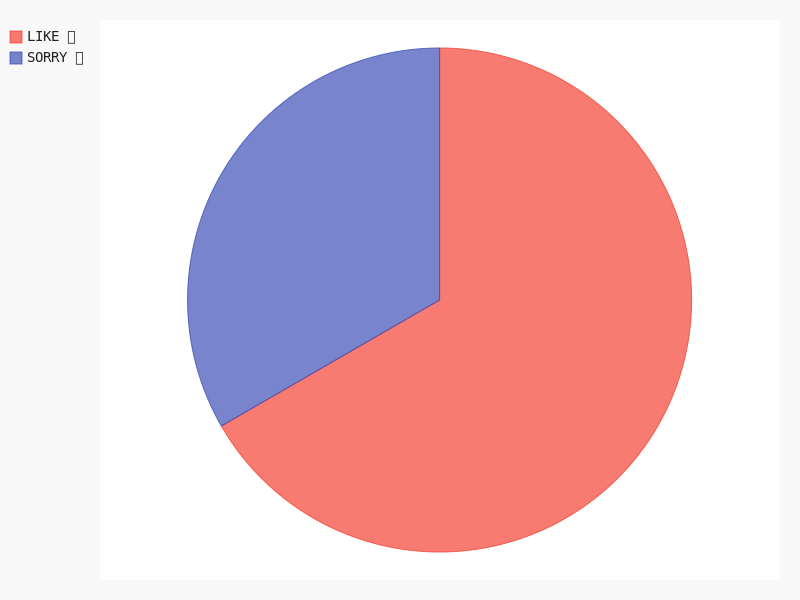

In [4]:
# Likes and reactions

like_table = pd.DataFrame({'time': [], 'reaction': []})
with zp.ZipFile(zip_path) as zip_file:
    folders = _aux_get_structure(zip_file)
    
#     print('likes_and_reactions/posts_and_comments.json' in zip_file)
#     print(dir(zip_file))
    paths = ['likes_and_reactions/posts_and_comments.json', 'likes_and_reactions/pages.json']
    for path in paths:
        try:
            # Likes on posts
            with zip_file.open('likes_and_reactions/posts_and_comments.json') as f:
                jdata = json.loads(f.read())

                likes = []
                times = []

                for i in jdata['reactions']:
                    times.append(i['timestamp'])
                    likes.append(i['data'][0]['reaction']['reaction'])

                temp_table = pd.DataFrame({'time': times, 'type': likes})
                temp_table.time = pd.to_datetime(temp_table.time, unit='s')
                like_table = pd.concat([like_table, temp_table])
        except KeyError as e:
            print("No likes or reactions")
        
#     try:
#         # Likes on pages
#         with zip_file.open('likes_and_reactions/pages.json') as f:
#             jdata = json.loads(f.read())

#             likes = []
#             times = []

#             for i in jdata['page_likes']:
#                 times.append(i['timestamp'])
#                 likes.append("LIKE")

#             # Tymczasowa tabela, żeby zamienić czas na datę
#             temp_table = pd.DataFrame({'time': times, 'type': likes})
#             temp_table.time = pd.to_datetime(temp_table.time, unit='s')
#             like_table = pd.concat([like_table, temp_table])
#     except KeyError as e:
#         print("No page likes")
like_table

# cum chart
vals, index = get_cum_graph(like_table['time'])
char = pygal.Line(fill=True, x_label_rotation=-45, show_legend=False)
char.x_labels = index.date
char.add('', list(vals))

name_to_e = {
    'ANGER': '😡',
    'HAHA': '😂',
    'LIKE': '👍',
    'LOVE': '❤️',
    'SORRY': '😢',
    'WOW': '😯'
}

by_type = like_table.groupby(like_table.type).count().time

indexes = [i + ' ' + name_to_e[i] for i in by_type.index]

chart = pygal.Pie()
for i, t in zip(indexes, list(by_type)):
    chart.add(i, t)
chart

# reszta tak jak w postach i likach

# # graph by years
# posts_by_year = like_table.groupby(like_table.time.dt.year).count()
# year_values = list(posts_by_year.time)
# year_indexes = list(posts_by_year.index)

# if len(posts_by_year) == 1:
#     year_values = [0] + year_values
#     year_indexes = [year_indexes[0] - 1] + year_indexes

# chart = pygal.Line(show_legend=False)
# chart.x_labels = year_indexes
# chart.add('', year_values)


In [5]:
# change
# dodano przypadek kiedy nie ma jakiegoś pliku z likami
# problem z emoji 🤔

kutwa
wtf
hewoo
codokurwy?
